# Analysis of bike-sharing data in NYC 

Analysis of last month's bike-sharing data in NYC (data source: https://citibikenyc.com/system-data), analyzing the potential for additional insurance, in particular for trips of over 30 minutes (potential premium of 0.20 USD)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, pandas_udf
from pyspark.sql.types import FloatType

import pandas as pd
import math
import os, sys

import matplotlib.pyplot as plt

In [2]:
monthdata = '202501'

In [19]:
from pyspark.sql import SparkSession

# Path to log4j.properties file
log4j_properties_path = "/log4j.properties"

# Create Spark session
spark = SparkSession.builder \
    .appName("citybike") \
    .config("spark.driver.extraJavaOptions", f"-Dlog4j.configuration=file:{log4j_properties_path}") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseCodeCacheFlushing -XX:-PrintGCDetails -XX:ReservedCodeCacheSize=512m") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseCodeCacheFlushing -XX:-PrintGCDetails -Xlog:disable") \
    .getOrCreate()

# Set log level to ERROR to suppress WARN messages
spark.sparkContext.setLogLevel("ERROR")

# Data Analysis citibikenyc


## Analysis potential for insurance coverage
- We could add insurance coverage for rides that last more than 30 minutes, how many trips would be covered?
- If we could charge 0.2 USD for each ride that takes longer than 30 minutes, how much revenue could we expect?

In [4]:
# read data
df = spark.read.csv(path=f'data/JC-{monthdata}-citibike-tripdata.csv',header=True, inferSchema=True)

# Calculate difference in minutes
df = df.withColumn(
    "duration_minutes",
    (unix_timestamp(df.ended_at) - unix_timestamp(df.started_at)) / 60
)

In [5]:
#df.show()

In [6]:
df_over30min = df.filter(df.duration_minutes >= 30)

In [7]:
trips_over_30min = df_over30min.distinct().count()
revenue = round(trips_over_30min * 0.2, 1)
formatted_revenue = "{:.2f}".format(revenue)

In [8]:
print(f'there are {trips_over_30min} trips over 30 minutes')
print(f'With a 0.2 USD premium for each ride of over 30 minutes, potential revenue would be {formatted_revenue} USD for the month of {monthdata}')

there are 661 trips over 30 minutes
With a 0.2 USD premium for each ride of over 30 minutes, potential revenue would be 132.20 USD for the month of 202501


## Analysis travel distance 

### Helper functions

Note: as there is no travel distance in the dataset but only 2 sets of latitude and longitude for the starting and ending bike station, the best estimate we can do is to compute the distance between those 2 points, this is done using the Haversine formula.

In [9]:
@pandas_udf(FloatType())
def haversine_distance(lat1: pd.Series, lon1: pd.Series, lat2: pd.Series, lon2: pd.Series) -> pd.Series:
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = lat1.apply(math.radians)
    lon1_rad = lon1.apply(math.radians)
    lat2_rad = lat2.apply(math.radians)
    lon2_rad = lon2.apply(math.radians)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = (dlat / 2).apply(math.sin)**2 + lat1_rad.apply(math.cos) * lat2_rad.apply(math.cos) * (dlon / 2).apply(math.sin)**2
    c = 2 * a.apply(lambda x: math.atan2(math.sqrt(x), math.sqrt(1 - x)))

    # Distance in kilometers
    distance = R * c
    return distance

In [10]:
def plot_histograms(pandas_df, postfix_plot_title:None):
    ### 1. Plot distribution
    plt.hist(pandas_df["haversine_distance_km"], bins=50, edgecolor='k')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Trip Distances  - {postfix_plot_title}')
    plt.show()


    ### 2. Compute custom bins (0-1,2-4,4-9,10+) & plot histogram
    # Define bins & labels
    bins = [0, 1, 4, 9, float('inf')]
    labels = ["0-1 km", "2-4 km", "4-9 km", "10+ km"]

    # Categorize distances
    pandas_df['haversine_distance_km_category'] = pd.cut(pandas_df["haversine_distance_km"], bins=bins, labels=labels, right=False)

    # Sort DataFrame by categorized column
    pandas_df = pandas_df.sort_values('haversine_distance_km_category')

    # Convert distance categories to strings
    pandas_df['haversine_distance_km_category'] = pandas_df['haversine_distance_km_category'].astype(str)

    # Plot histogram of custom bins
    plt.hist(pandas_df['haversine_distance_km_category'], bins=len(labels), edgecolor='k')
    tick_positions = [i + 0.5 for i in range(len(labels))]
    plt.xticks(ticks=tick_positions, labels=labels, ha='center')
    plt.xlabel('Distance Category')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Trip Distances by Category - {postfix_plot_title}')
    plt.show()

### Analysis travel distance - All trips

In [11]:
df = df.withColumn("haversine_distance_km",
                    haversine_distance(df.start_lat, df.start_lng, df.end_lat, df.end_lng))

In [12]:
#df.show()

In [13]:
# Convert to Pandas DataFrame
pd_df = df.toPandas()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=524288Kb used=29854Kb max_used=30150Kb free=494433Kb
 bounds [0x000000010c1f8000, 0x000000010df88000, 0x000000012c1f8000]
 total_blobs=10457 nmethods=9498 adapters=872
 compilation: disabled (not enough contiguous free space left)


In [14]:
pd_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_minutes,haversine_distance_km
0,880A0159BA5275FB,electric_bike,2025-01-16 17:50:49.136,2025-01-16 17:57:00.710,Hilltop,JC019,Pershing Field,JC024,40.731169,-74.057574,40.742677,-74.051789,member,6.183333,1.369339
1,1A5E1E274B2AF0AD,electric_bike,2025-01-31 06:10:41.818,2025-01-31 06:22:09.499,Hilltop,JC019,Jackson Square,JC063,40.731169,-74.057574,40.711130,-74.078900,member,11.466667,2.862713
2,EA9928D3C05B8377,classic_bike,2025-01-09 16:42:50.213,2025-01-09 17:04:12.870,Hilltop,JC019,Hoboken Terminal - Hudson St & Hudson Pl,HB101,40.731169,-74.057574,40.735938,-74.030305,member,21.366667,2.358034
3,3C42C367750B9292,electric_bike,2025-01-21 16:14:14.398,2025-01-21 16:37:10.458,Hilltop,JC019,Hoboken Terminal - Hudson St & Hudson Pl,HB101,40.731169,-74.057574,40.735938,-74.030305,member,22.933333,2.358034
4,94D3B0265A7BDE1F,classic_bike,2025-01-30 16:38:18.840,2025-01-30 17:04:08.166,Hilltop,JC019,Hoboken Terminal - Hudson St & Hudson Pl,HB101,40.731169,-74.057574,40.735938,-74.030305,member,25.833333,2.358034


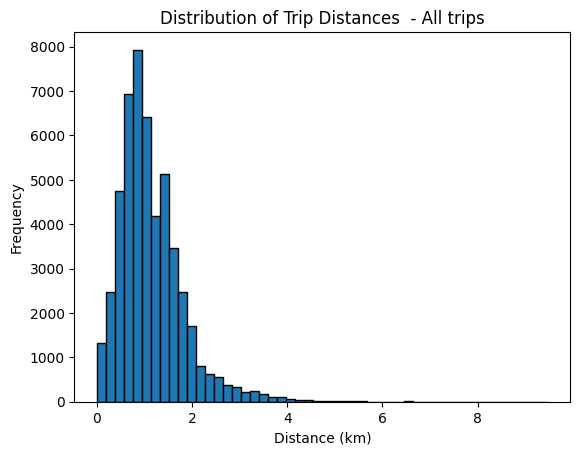

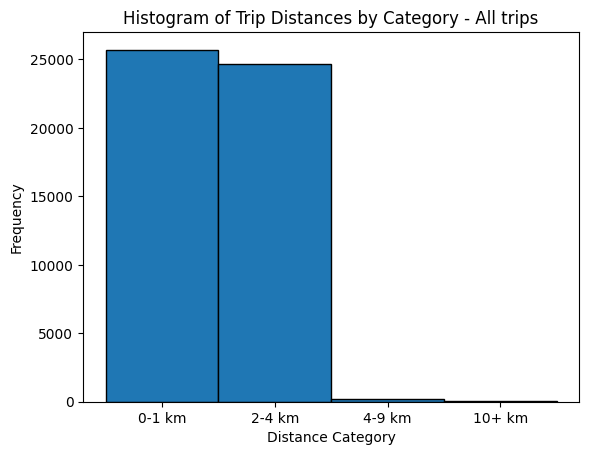

In [15]:
plot_histograms(pd_df, 'All trips')

### Analysis travel distance - Trips over 30 min

In [16]:
df_over30min = df.filter(df.duration_minutes >= 30)

In [17]:
# Convert to Pandas DataFrame
pd_df_over30min = df_over30min.toPandas()

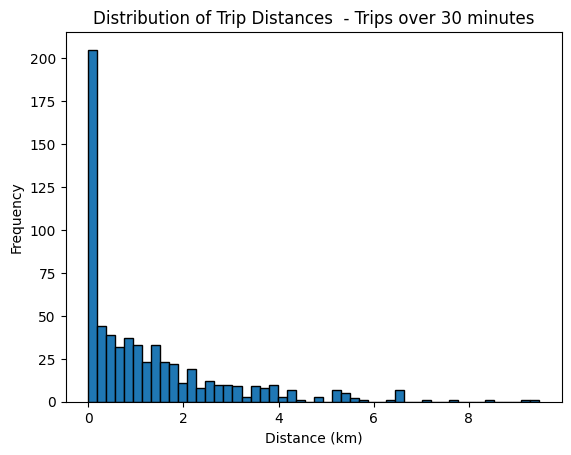

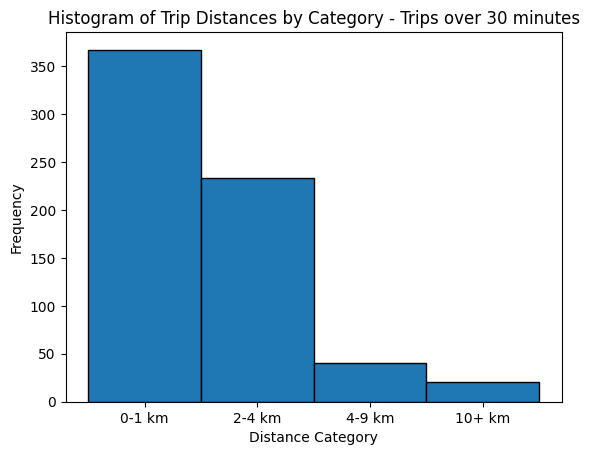

In [18]:
plot_histograms(pd_df_over30min, 'Trips over 30 minutes')

Most trips are short distance trips, even for trips over 30 minutes. This can be explained as those bike trips are done within New York City, with most trips being commutes within the city, and fewer leisure trips which would be longer distance.